In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import time

In [292]:
df0 = pd.read_csv("https://raw.githubusercontent.com/RutviKanani1008/YouTube_Comments_Spam_Detection/main/5000%20YT%20comments.csv", encoding='latin1')
df0.shape

(5000, 6)

In [210]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         5000 non-null   object
 1   Comment      5000 non-null   object
 2   Time         5000 non-null   object
 3   Likes        5000 non-null   int64 
 4   Reply Count  5000 non-null   int64 
 5   Spam         5000 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 234.5+ KB


In [211]:
df0.head()

,Name,Comment,Time,Likes,Reply Count,Spam
0,Taofeekat,&lt;????i make my first million investing in f...,2022-09-28T02:08:55Z,30,30,1
1,Angelina Jordan,&lt;?l will forever be indebted to you I will ...,2022-09-23T05:26:48Z,0,0,1
2,Fernandez Joe,<b>????I recommend a professional forex/Bitcoi...,2022-09-20T12:56:30Z,5,2,1
3,Jessica Billy,I think Im blessed because if not I wouldnt ...,2022-09-17T20:20:24Z,21,34,1
4,Allison Zar,<b>I recommend a professional broker to you g...,2022-09-05T09:19:30Z,19,27,1


In [212]:
df0[['Likes', 'Reply Count']].describe().T

,count,mean,std,min,25%,50%,75%,max
Likes,5000.0,27.0188,317.279457,0.0,0.0,0.0,2.0,14581.0
Reply Count,5000.0,3.4146,10.345014,0.0,0.0,0.0,1.0,106.0


In [213]:
df0.Spam.value_counts()

Spam
1    2500
0    2500
Name: count, dtype: int64

In [214]:
df0.isnull().sum().sum()

0

In [215]:
df0.duplicated().sum()

0

# Data Preprocessing

In [216]:
df = df0.copy()
df.shape

(5000, 6)

## Text Cleaning

In [217]:
# function for regex cleaning
def regex_clean(text):
    text = re.sub('\<\/{0,1}[a-z][^>]*\>','', text)  # remove html tags <a*> and </a>
    text = text.lower()
    text = re.sub('\d+[\d\,\.\:\/\%km]*', ' NUMBER', text)  # replace digits with NUMBER
    text = re.sub('\$\s*NUMBER', 'DOLLAR', text)  # replace $ with DOLLAR
    text = re.sub('\x92', "'", text)  # replace ' with '
    text = re.sub('[^\w\']+', ' ', text)  # remove non-alphanumerics
    return text

# function to clean text
def clean_text(col):
    # read html symbols
    from html import unescape
    col = col.map(lambda x: unescape(x))
    
    # regex cleaning
    col = col.map(lambda x: regex_clean(x))
    return col

In [218]:
df.Name = clean_text(df.Name)
df.Comment = clean_text(df.Comment)
df.head()

,Name,Comment,Time,Likes,Reply Count,Spam
0,taofeekat,i make my first million investing in forex tr...,2022-09-28T02:08:55Z,30,30,1
1,angelina jordan,l will forever be indebted to you i will cont...,2022-09-23T05:26:48Z,0,0,1
2,fernandez joe,i recommend a professional forex bitcoin brok...,2022-09-20T12:56:30Z,5,2,1
3,jessica billy,i think i'm blessed because if not i wouldn't ...,2022-09-17T20:20:24Z,21,34,1
4,allison zar,i recommend a professional broker to you guys ...,2022-09-05T09:19:30Z,19,27,1


In [219]:
# merge Name and Comment columns
df['Text'] = df['Name'] + ' ' + df['Comment']
df['Text'][:5]

0    taofeekat  i make my first million investing i...
1    angelina jordan  l will forever be indebted to...
2    fernandez joe  i recommend a professional fore...
3    jessica billy i think i'm blessed because if n...
4    allison zar i recommend a professional broker ...
Name: Text, dtype: object

In [220]:
# removing stopwords and lemmatize
def process_text(text):
    from nltk.tokenize import TreebankWordTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    
    tokenizer = TreebankWordTokenizer()
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [w for w in tokens if w not in stop_words]
    filtered = [lemmatizer.lemmatize(w) for w in filtered_tokens]
    filtered_text = ' '.join(filtered)
    return filtered_text

df['Text'] = df['Text'].apply(process_text)
df['Text'][:5]

0    taofeekat make first million investing forex t...
1    angelina jordan l forever indebted continue pr...
2    fernandez joe recommend professional forex bit...
3    jessica billy think 'm blessed would n't met s...
4    allison zar recommend professional broker guy ...
Name: Text, dtype: object

## Feature Engineering

In [221]:
df1 = df.drop(columns='Text').copy()
df1.head()

,Name,Comment,Time,Likes,Reply Count,Spam
0,taofeekat,i make my first million investing in forex tr...,2022-09-28T02:08:55Z,30,30,1
1,angelina jordan,l will forever be indebted to you i will cont...,2022-09-23T05:26:48Z,0,0,1
2,fernandez joe,i recommend a professional forex bitcoin brok...,2022-09-20T12:56:30Z,5,2,1
3,jessica billy,i think i'm blessed because if not i wouldn't ...,2022-09-17T20:20:24Z,21,34,1
4,allison zar,i recommend a professional broker to you guys ...,2022-09-05T09:19:30Z,19,27,1


In [222]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rutvi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [223]:
# sentiment analysis
def get_sentiment(text):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05: sentiment = 1
    elif scores['compound'] <= 0.05: sentiment = -1
    else: sentiment = 0
    return sentiment

In [224]:
df1['Sentiment'] = df1['Comment'].apply(get_sentiment)
df1.tail()

,Name,Comment,Time,Likes,Reply Count,Spam,Sentiment
4995,anjan das,she is so beautiful,2020-06-05T04:18:26Z,5,0,0,1
4996,humza navaid,NUMBER seconds in and i want to marry her i a...,2020-06-04T21:03:14Z,0,0,0,1
4997,aadil ranesh,she talks a lot like tanmay bakshi,2020-06-03T17:29:04Z,0,0,0,1
4998,fuzail ahmad,why does her face look like a bad deepfake,2020-06-03T11:17:48Z,1,0,0,-1
4999,kcmn NUMBER,so will bankers lose their jobs,2020-06-03T08:11:15Z,0,0,0,-1


In [225]:
df1.Sentiment.value_counts()

Sentiment
 1    3439
-1    1561
Name: count, dtype: int64

In [226]:
# comment length
df1['CommentLength'] = df['Comment'].map(lambda x: len(x))
df1.head(3)

,Name,Comment,Time,Likes,Reply Count,Spam,Sentiment,CommentLength
0,taofeekat,i make my first million investing in forex tr...,2022-09-28T02:08:55Z,30,30,1,1,164
1,angelina jordan,l will forever be indebted to you i will cont...,2022-09-23T05:26:48Z,0,0,1,1,215
2,fernandez joe,i recommend a professional forex bitcoin brok...,2022-09-20T12:56:30Z,5,2,1,1,126


In [227]:
# log transformation
df1['Likes'] = df1['Likes'].map(lambda x: np.log(x+1))
df1['Reply Count'] = df1['Reply Count'].map(lambda x: np.log(x+1))

In [228]:
# converting datetime
df1['Datetime'] = df1.Time.map(lambda x: re.sub('Z', '', re.sub('T', ' ', x)))
df1.Datetime = pd.DatetimeIndex(df1.Datetime)
df1.Datetime[:1]

0   2022-09-28 02:08:55
Name: Datetime, dtype: datetime64[ns]

In [229]:
df1['Date'] = df1.Datetime.dt.date
df1['Year'] = df1.Datetime.dt.year
df1['Month'] = df1.Datetime.dt.month
df1['Day'] = df1.Datetime.dt.day
df1['DayofYear'] = df1.Datetime.dt.dayofyear
df1['Hour'] = df1.Datetime.dt.hour
df1['DayofWeek'] = df1.Datetime.dt.dayofweek+1
df1['IsWeekend'] = df1.DayofWeek // 6 # 6&7 is Sat&Sun
df1['Period'] = df1['Date'].map(lambda x: re.search('.{7}', str(x)).group())

In [230]:
# part of day
def get_daypart(x):
    if ((x>=2) & (x<9)): daypart = 0  # 0=morning
    elif ((x>=9) & (x<18)): daypart = 1  # 1=daytime
    else: daypart = 2  # 2 = night
    return daypart

df1['DayPart'] = df1.Hour.map(lambda x: get_daypart(x))
df1.DayPart.value_counts()

DayPart
1    1943
2    1911
0    1146
Name: count, dtype: int64

In [231]:
df1[['Comment', 'Date']].duplicated().sum()

169

In [232]:
# duplicated comment of the same day
df1['DuplicatePost'] = 0
df1.loc[df1[['Comment', 'Date']].duplicated(), 'DuplicatePost'] = 1
df1.DuplicatePost.value_counts()

DuplicatePost
0    4831
1     169
Name: count, dtype: int64

In [233]:
df1.drop(columns=['Name', 'Datetime', 'Comment']).head(3)

,Time,Likes,Reply Count,Spam,Sentiment,CommentLength,Date,Year,Month,Day,DayofYear,Hour,DayofWeek,IsWeekend,Period,DayPart,DuplicatePost
0,2022-09-28T02:08:55Z,3.433987,3.433987,1,1,164,2022-09-28,2022,9,28,271,2,3,0,2022-09,0,0
1,2022-09-23T05:26:48Z,0.000000,0.000000,1,1,215,2022-09-23,2022,9,23,266,5,5,0,2022-09,0,0
2,2022-09-20T12:56:30Z,1.791759,1.098612,1,1,126,2022-09-20,2022,9,20,263,12,2,0,2022-09,1,0


## Outliers

In [234]:
df2 = df1.drop(columns=['Name', 'Datetime', 'Comment', 'Time']).copy()
df2.Likes = np.exp(df2.Likes)-1
df2['Reply Count'] = np.exp(df2['Reply Count'])-1
df2.shape

(5000, 16)

In [235]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Likes,5000.0,27.0188,317.279457,0.0,0.0,0.0,2.0,14581.0
Reply Count,5000.0,3.4146,10.345014,0.0,0.0,0.0,1.0,106.0
Spam,5000.0,0.5000,0.500050,0.0,0.0,0.5,1.0,1.0
Sentiment,5000.0,0.3756,0.926875,-1.0,-1.0,1.0,1.0,1.0
CommentLength,5000.0,185.7892,253.307819,0.0,51.0,110.0,208.0,4281.0
Year,5000.0,2021.0292,0.855391,2017.0,2021.0,2021.0,2022.0,2022.0
Month,5000.0,6.1580,3.336714,1.0,3.0,6.0,9.0,12.0
Day,5000.0,15.5244,8.620920,1.0,8.0,16.0,23.0,31.0
DayofYear,5000.0,171.7658,101.622212,1.0,88.0,157.0,257.0,366.0
Hour,5000.0,12.1672,7.072655,0.0,6.0,13.0,18.0,23.0


In [236]:
df2[['Likes', 'CommentLength']].quantile([0,.25,.5,.75,.95,.99,.999,1]).T

,0.000,0.250,0.500,0.750,0.950,0.990,0.999,1.000
Likes,0.0,0.0,0.0,2.0,51.0,443.00,4663.786,14581.0
CommentLength,0.0,51.0,110.0,208.0,652.2,1148.01,2593.100,4281.0


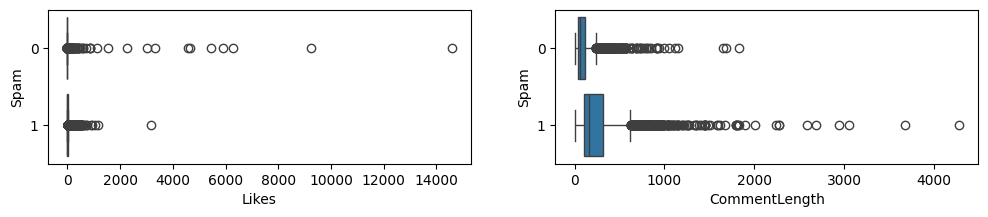

In [237]:
plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
sns.boxplot(data=df2, x='Likes', y='Spam', orient='h')
plt.subplot(1,2,2)
sns.boxplot(data=df2, x='CommentLength', y='Spam', orient='h')
plt.show()

In [238]:
# dropping extreme outliers > 2000
df2.drop(index = df2.loc[df2['Likes']>2000].index, inplace=True)

# dropping extreme outliers > .99 quantile and < 2
df2.drop(index = df2.loc[df2['CommentLength']>df2['CommentLength'].quantile(.99)].index, inplace=True)
df2.drop(index = df2.loc[df2['CommentLength']<2].index, inplace=True)
df2.shape

(4913, 16)

In [239]:
# dropping comment outlier in df
df.drop(index = df1.loc[df1['CommentLength']>df1['CommentLength'].quantile(.99)].index, inplace=True)
df.drop(index = df1.loc[df1['CommentLength']<2].index, inplace=True)
df.shape

(4924, 7)

## Missing Values

In [240]:
df2.isnull().sum()

Likes            0
Reply Count      0
Spam             0
Sentiment        0
CommentLength    0
Date             0
Year             0
Month            0
Day              0
DayofYear        0
Hour             0
DayofWeek        0
IsWeekend        0
Period           0
DayPart          0
DuplicatePost    0
dtype: int64

# Exploratory Analysis

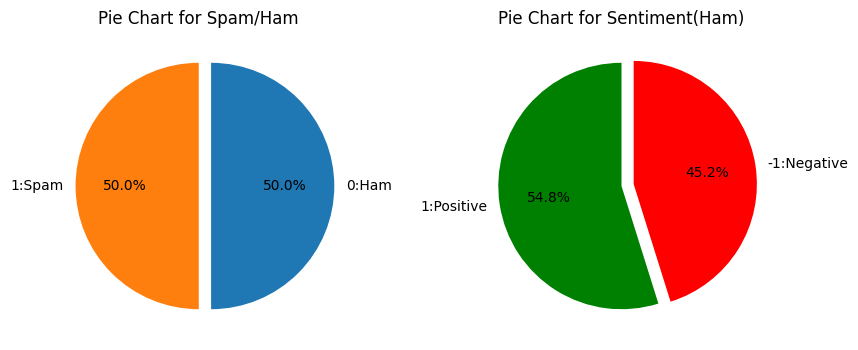

In [241]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pie(df1['Spam'].value_counts(), labels=['1:Spam', '0:Ham'],
       startangle=90, explode=[0,.1], autopct='%1.1f%%', colors=['#ff7f0e', '#1f77b4'])
plt.title("Pie Chart for Spam/Ham")
plt.subplot(1,2,2)
plt.pie(df1.loc[df1.Spam==0, 'Sentiment'].value_counts(), labels=['1:Positive', '-1:Negative'],
       startangle=90, explode=[0,.1], autopct='%1.1f%%', colors=['green', 'red'])
plt.title("Pie Chart for Sentiment(Ham)")
plt.show()

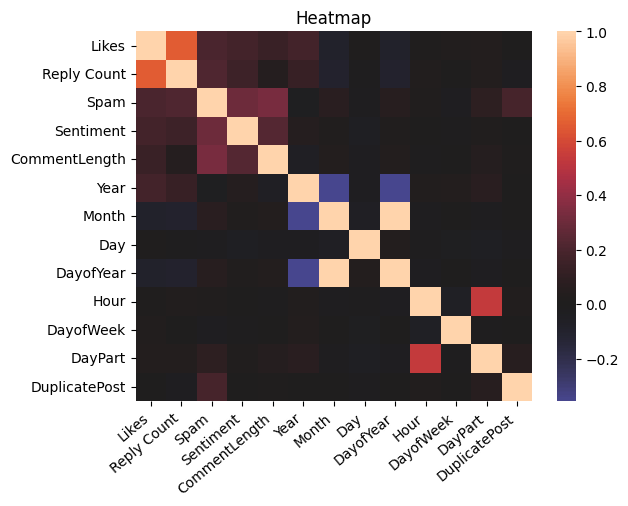

In [242]:
# heatmap
sns.heatmap(df1.select_dtypes(['float', 'int']).corr(), center=0)
plt.xticks(rotation=40, ha='right')
plt.title("Heatmap")
plt.show()

In [243]:
pd.crosstab(df1.Sentiment.replace({1:"Positive", -1:"Negative"}),\
           df1.Spam.replace({0:"Ham", 1:"Spam"}))

Spam,Ham,Spam
Sentiment,,
Negative,1129,432
Positive,1371,2068


In [244]:
pd.crosstab(df1.DuplicatePost.replace({1:"Yes", 0:"No"}),\
           df1.Spam.replace({0:"Ham", 1:"Spam"}))

Spam,Ham,Spam
DuplicatePost,,
No,2497,2334
Yes,3,166


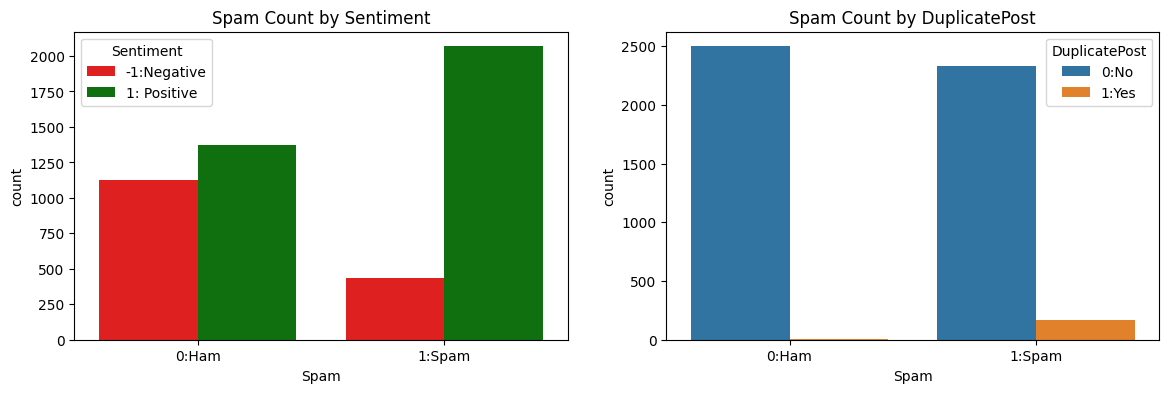

In [245]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.countplot(data=df1, x='Spam', hue='Sentiment', palette=['red', 'green'])
plt.xticks(ticks=[0,1], labels=["0:Ham", "1:Spam"])
plt.legend(["-1:Negative", "1: Positive"], title="Sentiment")
plt.title("Spam Count by Sentiment")
plt.subplot(1,2,2)
sns.countplot(data=df1, x='Spam', hue='DuplicatePost', palette=['#1f77b4', '#ff7f0e'])
plt.xticks(ticks=[0,1], labels=["0:Ham", "1:Spam"])
plt.legend(["0:No", "1:Yes"], title="DuplicatePost")
plt.title("Spam Count by DuplicatePost")
plt.show()

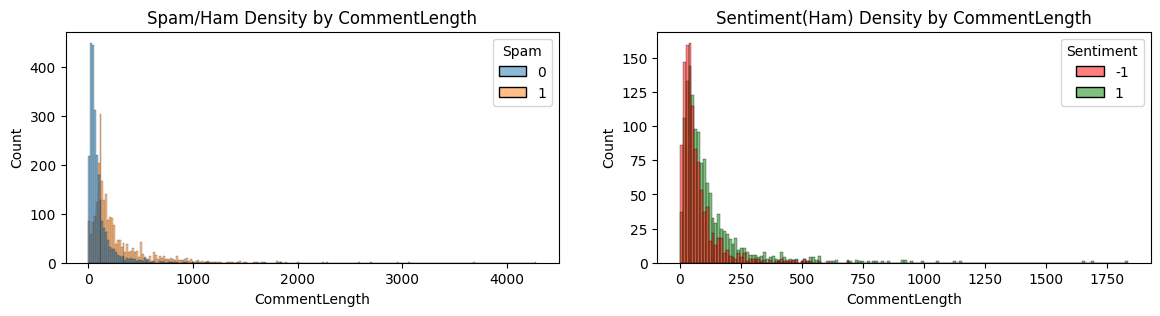

In [246]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.histplot(data=df1, x='CommentLength', hue='Spam', palette=['#1f77b4', '#ff7f0e'])
plt.title("Spam/Ham Density by CommentLength")
plt.subplot(1,2,2)
sns.histplot(data=df1[df1.Spam==0], x='CommentLength', hue='Sentiment', palette=['red', 'green'])
plt.title("Sentiment(Ham) Density by CommentLength")
plt.show()

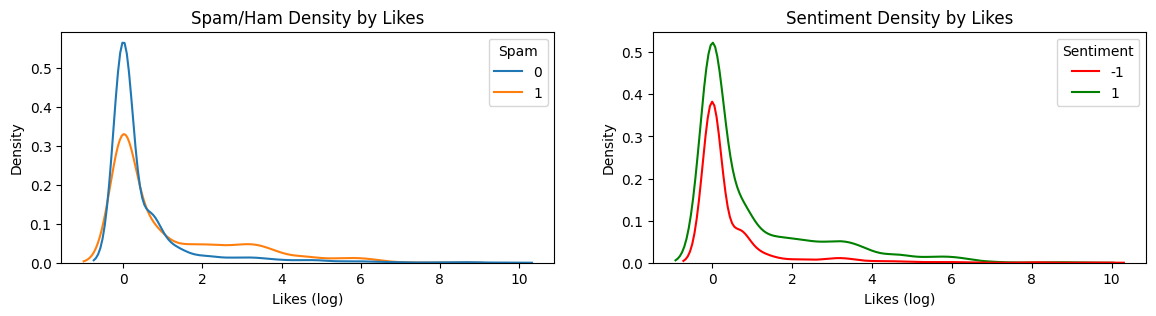

In [247]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.kdeplot(data=df1, x='Likes', hue='Spam', palette=['#1f77b4', '#ff7f0e'])
plt.title("Spam/Ham Density by Likes")
plt.xlabel("Likes (log)")
plt.subplot(1,2,2)
sns.kdeplot(data=df1, x='Likes', hue='Sentiment', palette=['red', 'green'])
plt.title("Sentiment Density by Likes")
plt.xlabel("Likes (log)")
plt.show()

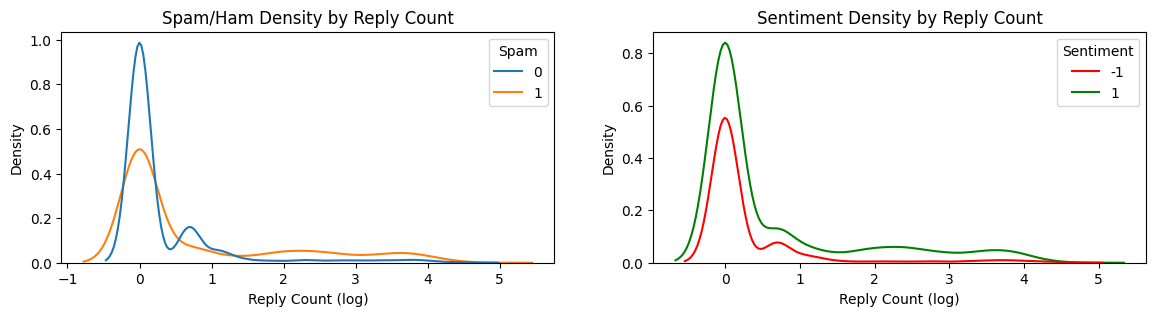

In [248]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.kdeplot(data=df1, x='Reply Count', hue='Spam', palette=['#1f77b4', '#ff7f0e'])
plt.title("Spam/Ham Density by Reply Count")
plt.xlabel("Reply Count (log)")
plt.subplot(1,2,2)
sns.kdeplot(data=df1, x='Reply Count', hue='Sentiment', palette=['red', 'green'])
plt.title("Sentiment Density by Reply Count")
plt.xlabel("Reply Count (log)")
plt.show()

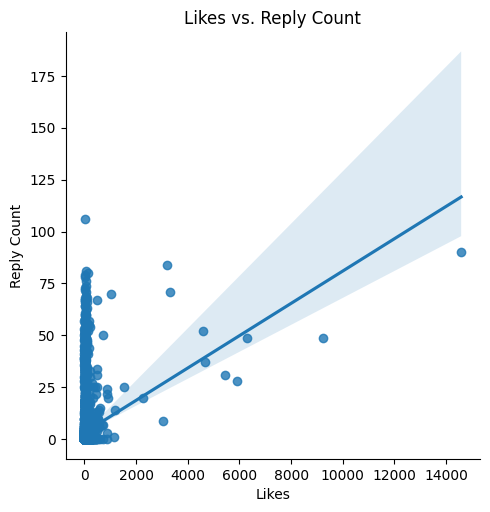

In [249]:
sns.lmplot(data=df, x='Likes', y='Reply Count')
plt.title("Likes vs. Reply Count")
plt.show()

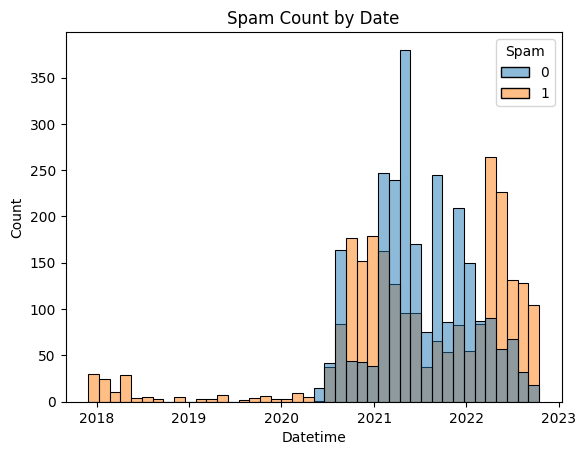

In [250]:
plt.title("Spam Count by Date")
sns.histplot(data=df1, x='Datetime', hue='Spam')
plt.show()

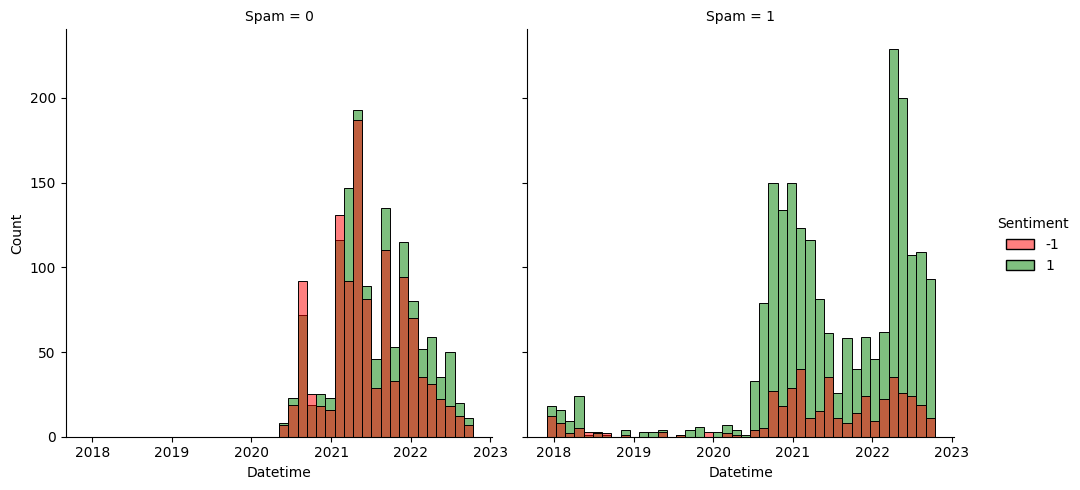

In [251]:
sns.displot(data=df1, x='Datetime', hue='Sentiment', col='Spam', palette=['red','green'])
plt.show()

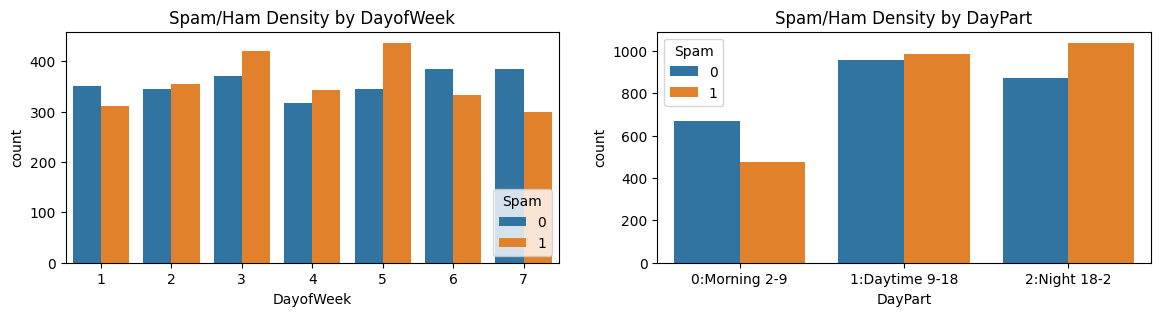

In [252]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.countplot(data=df1, x='DayofWeek', hue='Spam')
plt.title("Spam/Ham Density by DayofWeek")
plt.legend(loc='lower right', title="Spam")
plt.subplot(1,2,2)
sns.countplot(data=df1, x='DayPart', hue='Spam')
plt.title("Spam/Ham Density by DayPart")
plt.xticks(ticks=[0,1,2], labels=["0:Morning 2-9", "1:Daytime 9-18", "2:Night 18-2"])
plt.show()

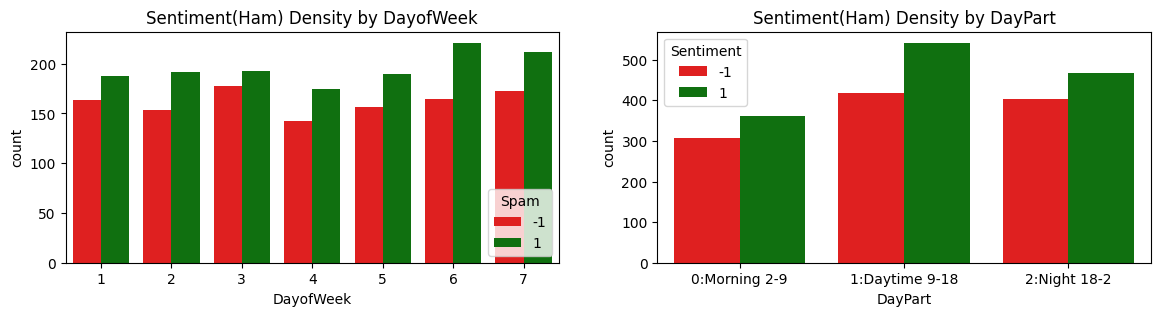

In [253]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.countplot(data=df1[df1.Spam==0], x='DayofWeek', hue='Sentiment', palette=['red','green'])
plt.title("Sentiment(Ham) Density by DayofWeek")
plt.legend(loc='lower right', title="Spam")
plt.subplot(1,2,2)
sns.countplot(data=df1[df1.Spam==0], x='DayPart', hue='Sentiment', palette=['red','green'])
plt.title("Sentiment(Ham) Density by DayPart")
plt.xticks(ticks=[0,1,2], labels=["0:Morning 2-9", "1:Daytime 9-18", "2:Night 18-2"])
plt.show()

In [254]:
# test for same median, continuous variables against Spam
def MannWhitneyU(df, grp, alpha=.05):
    from scipy.stats import mannwhitneyu
    res = []
    for col in df:
        p_val = mannwhitneyu(df[col][grp==0], df[col][grp==1])[1]
        if p_val < alpha: corr='Different'
        else: corr="Same"
        entry = {'Var1':col, 'Var2':grp.name, 'Median':corr, 'alpha':alpha, 'p_val':p_val}
        res.append(entry)
    return pd.DataFrame(res)

MannWhitneyU(df1[['Likes', 'Reply Count', 'CommentLength']], df1['Spam'])

,Var1,Var2,Median,alpha,p_val
0,Likes,Spam,Different,0.05,3.794234e-48
1,Reply Count,Spam,Different,0.05,8.106920e-30
2,CommentLength,Spam,Different,0.05,2.476691e-262


In [255]:
# test for independence, categorical variables against Spam
def chi_square(c1, c2, alpha=0.05):
    from scipy.stats import chi2_contingency
    res = []
    for col in c1:
        crosstab = np.array(pd.crosstab(c1[col], c2, margins = False))
        chi_sq, p_val, *a = chi2_contingency(crosstab)
        cram_V = np.sqrt(chi_sq/(np.sum(crosstab)*(min(crosstab.shape)-1)))
        if p_val < alpha: corr="Yes"
        else: corr="No"
        entry = {'Var1':col, 'Var2':c2.name, 'Correlated':corr, 'alpha':alpha, 'p_val':round(p_val), "Cramer's V":cram_V.round(3)}
        res.append(entry)
    return pd.DataFrame(res)

chi_square(df1[['Sentiment', 'Year', 'DayofWeek', 'IsWeekend', 'DayPart']], df1['Spam'])

,Var1,Var2,Correlated,alpha,p_val,Cramer's V
0,Sentiment,Spam,Yes,0.05,0,0.300
1,Year,Spam,Yes,0.05,0,0.374
2,DayofWeek,Spam,Yes,0.05,0,0.080
3,IsWeekend,Spam,Yes,0.05,0,0.061
4,DayPart,Spam,Yes,0.05,0,0.097


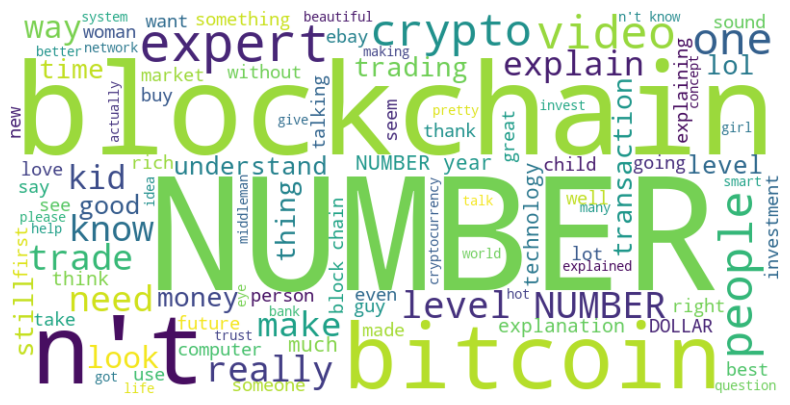

In [256]:
# wordcloud for Ham
from wordcloud import WordCloud
word_cloud = WordCloud(width=800, height=400, max_words=100, min_word_length=3, background_color='white')
word_cloud.generate(' '.join(df.loc[df.Spam==0, 'Text']))
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

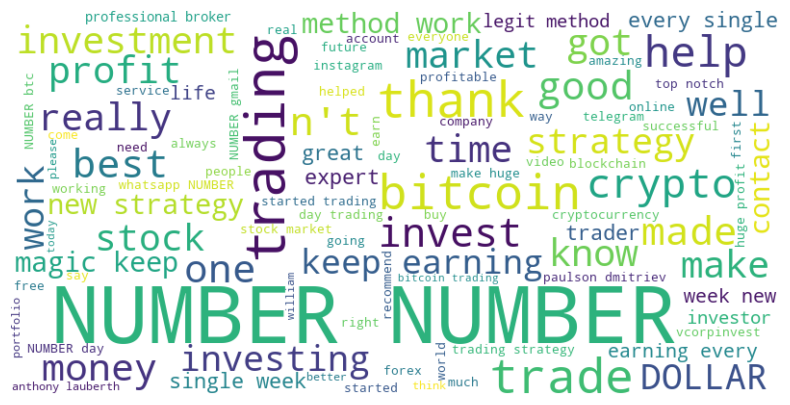

In [257]:
# wordcloud for Spam
from wordcloud import WordCloud
word_cloud = WordCloud(width=800, height=400, max_words=100, min_word_length=3, background_color='white')
word_cloud.generate(' '.join(df.loc[df.Spam==1, 'Text']))
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Models

Two approaches for spam prediction will be tested.
- Approach A: prediction models will be built on NLP (natural language processing) application on the name and comment text.
- Approach B: prediction models will be built based on related attributes of the comment posts.

## Approach A: NLP

### Preparation

In [258]:
# split train test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.Text, df.Spam, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3939,) (985,) (3939,) (985,)


In [259]:
# vectorizing text into sparse matrix
from sklearn.feature_extraction.text import TfidfVectorizer
trans_vect = TfidfVectorizer(min_df=3)
X_train = trans_vect.fit_transform(X_train)
X_test = trans_vect.transform(X_test)

In [260]:
X_train

<3939x3072 sparse matrix of type '<class 'numpy.float64'>'
	with 56247 stored elements in Compressed Sparse Row format>

In [261]:
X_test

<985x3072 sparse matrix of type '<class 'numpy.float64'>'
	with 13393 stored elements in Compressed Sparse Row format>

In [262]:
def model_evaluate_method(name, model, X_train, y_train, X_test, y_test):
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    from sklearn.metrics import classification_report, confusion_matrix
    
    t1 = time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    t2 = time()
    
    crossval = cross_val_score(model, X_train, y_train, cv=4, n_jobs=-1)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    entry = {'CrossVal':crossval.mean(), 'Accuracy':accuracy, 'F1 Score':f1, 'ROC-AUC':auc, 'Time':t2-t1}
    return pd.DataFrame(entry, index=[name]), report, confusion

### Naive Bayes Classifier

In [263]:
from sklearn.naive_bayes import MultinomialNB
nbc = MultinomialNB()
Result_NBC = model_evaluate_method("A1. Naive Bayes", nbc, X_train, y_train, X_test, y_test)
Result_NBC[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
A1. Naive Bayes,0.8901,0.8873,0.8872,0.8891,0.007


### Logistic Regression

In [264]:
# solver + penalty + C + class_weight
from sklearn.linear_model import LogisticRegression
param1 = ['lbfgs', 'liblinear', 'liblinear']
param2 = ['l2', 'l1', 'l2']
param3 = [1,5,8]

Result = []

for p1, p2 in zip(param1, param2):
    for p3 in param3:
        lrm = LogisticRegression(solver=p1, penalty=p2, C=p3)
        res = model_evaluate_method(f"{p1}+{p2}+{p3}", lrm, X_train, y_train, X_test, y_test)
        Result.append(res)

# Convert the list of tuples to a DataFrame
Result_df = pd.concat([r[0] for r in Result], axis=0)

# Display Results
Result_df.sort_values(by='Accuracy', ascending=False)[:5]

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
lbfgs+l2+5,0.906070,0.898477,0.898513,0.899021,0.106714
liblinear+l2+5,0.906070,0.898477,0.898513,0.899021,0.014960
lbfgs+l2+8,0.905056,0.897462,0.897497,0.898119,0.105718
liblinear+l2+8,0.905056,0.897462,0.897497,0.898119,0.023937
lbfgs+l2+1,0.902006,0.895431,0.895435,0.895322,0.099733


In [265]:
# best logistic regression
lrm = LogisticRegression(solver='liblinear', C=8)
Result_LR = model_evaluate_method("A2. Logistic Regression", lrm, X_train, y_train, X_test, y_test)
Result_LR[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
A2. Logistic Regression,0.9051,0.8975,0.8975,0.8981,0.0219


### Support Vector Classifier

In [266]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param = {'kernel':['rbf','linear','sigmoid','poly'],
        'C':[1,5,8],
        'degree':[3,2,4],
        'random_state':[42]}

model = GridSearchCV(SVC(), param_grid=param, cv=4, n_jobs=-1)
model.fit(X_train, y_train)
print(model.best_params_, "\n")

svc = SVC(**model.best_params_)
Result_SVC = model_evaluate_method('A3. Support Vector Machine', svc, X_train, y_train, X_test, y_test)
Result_SVC[0].round(4)

{'C': 8, 'degree': 3, 'kernel': 'rbf', 'random_state': 42} 



,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
A3. Support Vector Machine,0.9089,0.8985,0.8985,0.8985,2.1214


### Random Forest Classifier

In [267]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
scores = []
scores_test = []
for i in range(50, 251, 50):
    rfc = RandomForestClassifier(n_estimators=i, random_state=43, n_jobs=-1)
    rfc.fit(X_train, y_train)
    scores.append(cross_val_score(rfc, X_train, y_train, cv=4).mean())
    scores_test.append(rfc.fit(X_train, y_train).score(X_test, y_test))

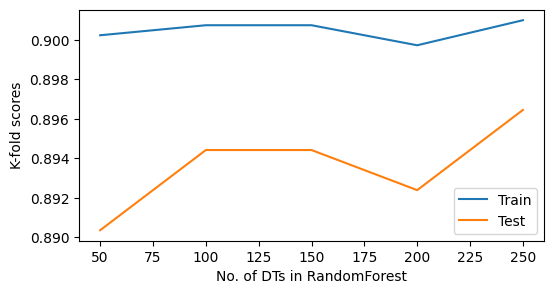

In [268]:
plt.figure(figsize=(6,3))
plt.plot(range(50, 251, 50), scores, label="Train")
plt.plot(range(50, 251, 50), scores_test, label="Test")
plt.xlabel('No. of DTs in RandomForest')
plt.ylabel('K-fold scores')
plt.legend()
plt.show()

In [269]:
# criterion
param1 = ['gini', 'entropy', 'log_loss']
Result = pd.DataFrame([])
for p1 in param1:
    rfc = RandomForestClassifier(n_estimators=200, criterion=p1, random_state=43, n_jobs=-1)
    res = model_evaluate_method(f"{p1}", rfc, X_train, y_train, X_test, y_test)[0]
    Result = pd.concat([Result, res], axis=0)
Result.sort_values(['Accuracy', 'CrossVal'], ascending=False)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
entropy,0.903784,0.894416,0.894442,0.894573,3.444775
log_loss,0.903784,0.894416,0.894442,0.894573,3.530230
gini,0.899722,0.892386,0.892419,0.892692,3.440596


In [270]:
# max_depth + max_features
param1 = [None, 80, 100, 120]
param2 = ['sqrt', 46, 38, 30]
Result = pd.DataFrame([])
for p1 in param1:
    for p2 in param2:
        rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=p1, max_features=p2)
        Result = pd.concat([Result, res], axis=0)
Result.sort_values(['Accuracy', 'CrossVal'], ascending=False)[:5]

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
log_loss,0.903784,0.894416,0.894442,0.894573,3.53023
log_loss,0.903784,0.894416,0.894442,0.894573,3.53023
log_loss,0.903784,0.894416,0.894442,0.894573,3.53023
log_loss,0.903784,0.894416,0.894442,0.894573,3.53023
log_loss,0.903784,0.894416,0.894442,0.894573,3.53023


In [271]:
# best random forest classifier
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=100, max_features=12)
Result_RF = model_evaluate_method('A4. Random Forest', rfc, X_train, y_train, X_test, y_test)
Result_RF[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
A4. Random Forest,0.8919,0.8812,0.8807,0.8793,6.5724


### Extreme Gradient Boosting

In [272]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42, n_jobs=-1)
Result_XGB = model_evaluate_method('A5. XG Boost', xgb, X_train, y_train, X_test, y_test)
Result_XGB[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
A5. XG Boost,0.8941,0.8914,0.8913,0.8905,1.9466


## Approach B: Comment Attributes

### Preparation

In [273]:
X1 = df1.drop(columns=['Name', 'Comment', 'Time', 'Datetime', 'Spam', 'Date', 'Period'])
X1.head(3)

,Likes,Reply Count,Sentiment,CommentLength,Year,Month,Day,DayofYear,Hour,DayofWeek,IsWeekend,DayPart,DuplicatePost
0,3.433987,3.433987,1,164,2022,9,28,271,2,3,0,0,0
1,0.000000,0.000000,1,215,2022,9,23,266,5,5,0,0,0
2,1.791759,1.098612,1,126,2022,9,20,263,12,2,0,1,0


In [274]:
# split train test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, df1.Spam, test_size=0.2)
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)

(4000, 13) (1000, 13) (4000,) (1000,)


In [275]:
# minmax scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_sc_train = sc.fit_transform(X_train1)
X_sc_test = sc.transform(X_test1)

### Logistic Regression

In [276]:
# solver + penalty + C + class_weight
param1 = ['lbfgs', 'liblinear', 'liblinear']
param2 = ['l2', 'l1', 'l2']
param3 = [1,5,8]

Result = []

for p1, p2 in zip(param1, param2):
    for p3 in param3:
        lrm = LogisticRegression(solver=p1, penalty=p2, C=p3)
        res = model_evaluate_method(f"{p1}+{p2}+{p3}", lrm, X_sc_train, y_train1, X_sc_test, y_test1)
        Result.append(res)

# Convert the list of tuples to a DataFrame
Result_df = pd.concat([r[0] for r in Result], axis=0)

# Display Results
Result_df.sort_values(by='Accuracy', ascending=False)[:5]

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
liblinear+l1+5,0.74575,0.740,0.739446,0.740924,0.184542
liblinear+l1+8,0.74600,0.740,0.739446,0.740924,0.043883
liblinear+l1+1,0.74300,0.736,0.735486,0.736887,0.102726
lbfgs+l2+5,0.74175,0.730,0.729522,0.730849,0.043883
lbfgs+l2+8,0.74575,0.730,0.729568,0.730813,0.035904


In [277]:
# best logistic regression
lrm = LogisticRegression(solver='liblinear',penalty='l1', C=8)
Result_LR_B = model_evaluate_method("B1. Logistic Regression", lrm, X_sc_train, y_train1, X_sc_test, y_test1)
Result_LR_B[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
B1. Logistic Regression,0.746,0.74,0.7394,0.7409,0.2095


### Decision Tree

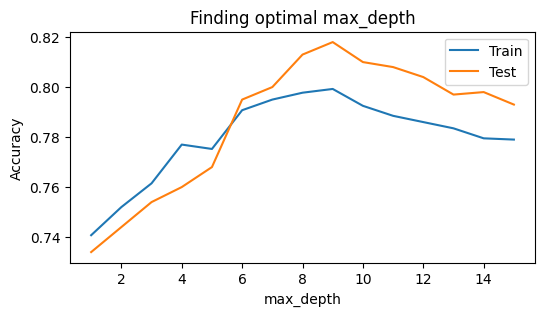

In [278]:
from sklearn.tree import DecisionTreeClassifier
scores = []
scores_test = []
for i in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=i, random_state=42)
    scores.append(cross_val_score(model, X_train1, y_train1, cv=4).mean())
    scores_test.append(model.fit(X_train1, y_train1).score(X_test1, y_test1))
    
plt.figure(figsize=(6,3))
plt.plot(range(1, 16, 1), scores, label="Train")
plt.plot(range(1, 16, 1), scores_test, label="Test")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Finding optimal max_depth")
plt.legend()
plt.show()

In [279]:
# criterion + max_features
param1 = ['gini', 'entropy', 'log_loss']
param2 = ['sqrt',4,2]
param3 = [7,8,9]

Result = []

for p1 in param1:
    for p2 in param2:
        for p3 in param3:
            model = DecisionTreeClassifier(criterion=p1, max_depth=p3, max_features=p2)
            res = model_evaluate_method(f"{p1}+{p2}+{p3}", model, X_train1, y_train1, X_test1, y_test1)
            Result.append(res)
            
# Convert the list of tuples to a DataFrame
Result_df = pd.concat([r[0] for r in Result], axis=0)

# Display Results
Result_df.sort_values(by='Accuracy', ascending=False)[:5]

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
log_loss+sqrt+9,0.76575,0.815,0.814588,0.815966,0.008976
log_loss+4+9,0.77525,0.806,0.805853,0.806621,0.011006
entropy+4+8,0.78075,0.804,0.803802,0.804693,0.009974
gini+4+8,0.77825,0.792,0.792012,0.792005,0.008974
entropy+4+9,0.77000,0.790,0.789284,0.791156,0.008993


In [280]:
# best decision tree classifier
dtcl = DecisionTreeClassifier(max_features=4, max_depth=9, random_state=42)
Result_DT_B = model_evaluate_method('B2. Decision Tree', dtcl, X_train1, y_train1, X_test1, y_test1)
Result_DT_B[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
B2. Decision Tree,0.783,0.793,0.7927,0.7939,0.012


### Random Forest Classifier

In [281]:
# random forest classifier
rfc1 = RandomForestClassifier(random_state=42, n_jobs=-1)
Result_RF_B = model_evaluate_method('B3. Random Forest', rfc1, X_train1, y_train1, X_test1, y_test1)
Result_RF_B[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
B3. Random Forest,0.8265,0.85,0.85,0.8501,0.3996


In [282]:
# feature importance
rfc1.fit(X_train1, y_train1)
feature_importances = pd.DataFrame({'Importance': rfc1.feature_importances_}, index=X1.columns)
feature_importances = feature_importances.sort_values("Importance", ascending=False)
feature_importances

,Importance
CommentLength,0.299702
DayofYear,0.115188
Year,0.103268
Day,0.082889
Hour,0.073525
Likes,0.062939
Month,0.061378
Reply Count,0.052055
Sentiment,0.051436
DayofWeek,0.045643


### Extreme Gradient Boosting

In [283]:
xgb1 = XGBClassifier(random_state=42, n_jobs=-1)
Result_XGB_B = model_evaluate_method('B4. XG Boost', xgb1, X_train1, y_train1, X_test1, y_test1)
Result_XGB_B[0].round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
B4. XG Boost,0.8235,0.827,0.827,0.8269,0.1865


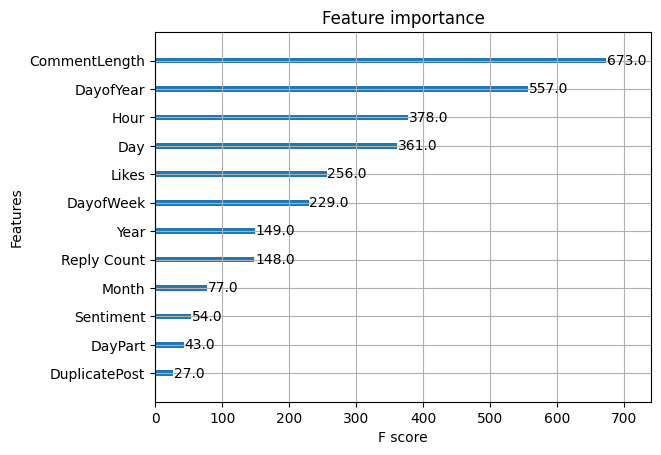

<Figure size 300x400 with 0 Axes>

In [284]:
from xgboost import plot_importance
plot_importance(xgb1)
plt.figure(figsize=(3,4))
plt.show()

## Model Evaluation

In [285]:
Result_Evaluate_A = pd.concat([Result_NBC[0], Result_LR[0], Result_SVC[0], Result_RF[0], Result_XGB[0]])
Result_Evaluate_A.round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
A1. Naive Bayes,0.8901,0.8873,0.8872,0.8891,0.0070
A2. Logistic Regression,0.9051,0.8975,0.8975,0.8981,0.0219
A3. Support Vector Machine,0.9089,0.8985,0.8985,0.8985,2.1214
A4. Random Forest,0.8919,0.8812,0.8807,0.8793,6.5724
A5. XG Boost,0.8941,0.8914,0.8913,0.8905,1.9466


In [286]:
Result_Evaluate_B = pd.concat([Result_LR_B[0], Result_DT_B[0], Result_RF_B[0], Result_XGB_B[0]])
Result_Evaluate_B.round(4)

,CrossVal,Accuracy,F1 Score,ROC-AUC,Time
B1. Logistic Regression,0.7460,0.740,0.7394,0.7409,0.2095
B2. Decision Tree,0.7830,0.793,0.7927,0.7939,0.0120
B3. Random Forest,0.8265,0.850,0.8500,0.8501,0.3996
B4. XG Boost,0.8235,0.827,0.8270,0.8269,0.1865


In [287]:
print(Result_SVC[1])
print(Result_SVC[2])

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       511
           1       0.89      0.90      0.89       474

    accuracy                           0.90       985
   macro avg       0.90      0.90      0.90       985
weighted avg       0.90      0.90      0.90       985

[[459  52]
 [ 48 426]]


In [288]:
print(Result_NBC[1])
print(Result_NBC[2])

              precision    recall  f1-score   support

           0       0.93      0.84      0.89       511
           1       0.85      0.94      0.89       474

    accuracy                           0.89       985
   macro avg       0.89      0.89      0.89       985
weighted avg       0.89      0.89      0.89       985

[[430  81]
 [ 30 444]]


In [289]:
print(Result_LR[1])
print(Result_LR[2])

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       511
           1       0.88      0.92      0.90       474

    accuracy                           0.90       985
   macro avg       0.90      0.90      0.90       985
weighted avg       0.90      0.90      0.90       985

[[450  61]
 [ 40 434]]


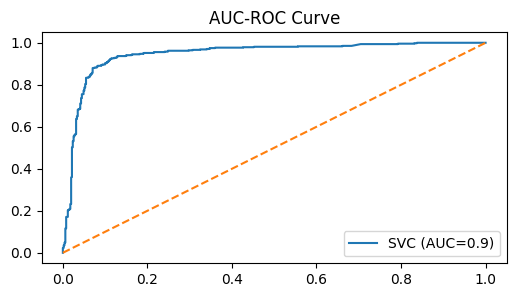

In [290]:
from sklearn.metrics import roc_curve, roc_auc_score
svc = SVC(kernel='rbf', degree=3, C=1, random_state=42, probability=True)
svc.fit(X_train, y_train)
y_prob = svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = round(roc_auc_score(y_test, svc.predict(X_test)),2)

plt.figure(figsize=(6,3))
plt.plot(fpr, tpr, label=f"SVC (AUC={auc})")
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='dashed')
plt.title("AUC-ROC Curve")
plt.show()

In [291]:
from sklearn.preprocessing import binarize
from sklearn.metrics import classification_report, confusion_matrix
y_pred_thresh = binarize(y_prob.reshape(-1,1), threshold=0.9)
print(classification_report(y_test, y_pred_thresh))
print(confusion_matrix(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       511
           1       0.94      0.72      0.81       474

    accuracy                           0.84       985
   macro avg       0.86      0.84      0.84       985
weighted avg       0.86      0.84      0.84       985

[[489  22]
 [134 340]]
